In [30]:
import os
import numpy as np
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from functools import partial
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib import pyplot as plt

# ===============================================
# Data loading & preprocessing (same as before)
# ===============================================
def load_and_preprocess_data(file_path, test_size=0.3, random_state=42):
    df = pd.read_csv(file_path)
    print("Loaded dataset with shape:", df.shape)
    
    target_col = "diagnosis"  # or update as needed
    feature_cols = df.columns[2:]
    X = df[feature_cols].values
    y = df[target_col].values
    
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    if np.isnan(X_scaled).any():
        print("⚠️ Warning: NaNs found in dataset! Replacing with zeros.")
        X_scaled = np.nan_to_num(X_scaled)
    
    unique, counts = np.unique(y, return_counts=True)
    print("Class Distribution:", dict(zip(unique, counts)))
    
    min_class_samples = min(counts)
    test_size = min(0.3, max(0.1, (min_class_samples - 1) / len(y)))
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state, 
        stratify=y if min_class_samples > 1 else None
    )
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)
    
    print("NaNs in X_train:", torch.isnan(X_train_tensor).sum().item())
    print("NaNs in y_train:", torch.isnan(y_train_tensor).sum().item())
    
    input_dim = X_train_tensor.shape[1]
    output_dim = 1  # binary classification (for Bernoulli)
    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, input_dim, output_dim

# ===============================================
# Bayesian Neural Network Definition
# ===============================================
class BayesianFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=16):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

    def model(self, X, y=None):
        batch_size = X.shape[0]
        # Prior for weights and biases
        w1 = pyro.sample("w1", dist.Normal(torch.zeros(self.input_dim, self.hidden_dim),
                                             torch.ones(self.input_dim, self.hidden_dim)).to_event(2))
        b1 = pyro.sample("b1", dist.Normal(torch.zeros(self.hidden_dim),
                                             torch.ones(self.hidden_dim)).to_event(1))
        w2 = pyro.sample("w2", dist.Normal(torch.zeros(self.hidden_dim, 1),
                                             torch.ones(self.hidden_dim, 1)).to_event(2))
        b2 = pyro.sample("b2", dist.Normal(torch.tensor(0.0),
                                             torch.tensor(1.0)))
        # Forward pass through the network
        hidden = torch.relu(torch.matmul(X, w1) + b1)
        logits = torch.matmul(hidden, w2) + b2
        probs = torch.sigmoid(logits).squeeze(-1)
        
        # Record logits for later (optional, if you want to use them in evaluation)
        pyro.deterministic("logits", logits.squeeze(-1))
        
        with pyro.plate("data", batch_size):
            pyro.sample("obs", dist.Bernoulli(probs), obs=y)

    def forward(self, X):
        return self.model(X)

# ===============================================
# Boosting VI Components for the BNN
# ===============================================
# A boosted guide that uses an index to name its variational parameters
def boosted_guide(model_instance, X, y=None, index=0):
    input_dim = model_instance.input_dim
    hidden_dim = model_instance.hidden_dim

    # Variational parameters for first layer
    w1_loc = pyro.param(f"w1_loc_{index}", torch.zeros(input_dim, hidden_dim))
    w1_scale = pyro.param(f"w1_scale_{index}", torch.ones(input_dim, hidden_dim),
                           constraint=dist.constraints.positive)
    b1_loc = pyro.param(f"b1_loc_{index}", torch.zeros(hidden_dim))
    b1_scale = pyro.param(f"b1_scale_{index}", torch.ones(hidden_dim),
                           constraint=dist.constraints.positive)
    # Variational parameters for second layer
    w2_loc = pyro.param(f"w2_loc_{index}", torch.zeros(hidden_dim, 1))
    w2_scale = pyro.param(f"w2_scale_{index}", torch.ones(hidden_dim, 1),
                           constraint=dist.constraints.positive)
    b2_loc = pyro.param(f"b2_loc_{index}", torch.tensor(0.0))
    b2_scale = pyro.param(f"b2_scale_{index}", torch.tensor(1.0),
                           constraint=dist.constraints.positive)

    pyro.sample("w1", dist.Normal(w1_loc, w1_scale).to_event(2))
    pyro.sample("b1", dist.Normal(b1_loc, b1_scale).to_event(1))
    pyro.sample("w2", dist.Normal(w2_loc, w2_scale).to_event(2))
    pyro.sample("b2", dist.Normal(b2_loc, b2_scale))

# The RELBO function, adapted for the network’s weights. Note we block the names for our weight latents.
def relbo(model, guide, *args, **kwargs):
    approximation = kwargs.pop("approximation")
    traced_guide = poutine.trace(guide)
    elbo = Trace_ELBO(max_plate_nesting=1)
    loss_fn = elbo.differentiable_loss(model, traced_guide, *args, **kwargs)
    guide_trace = traced_guide.trace
    # Block all variational parameters so that previously trained components are not updated.
    replayed_approximation = poutine.trace(
        poutine.replay(poutine.block(approximation, expose=["w1", "b1", "w2", "b2"]), guide_trace)
    )
    approximation_trace = replayed_approximation.get_trace(*args, **kwargs)
    r_elbo = -loss_fn - approximation_trace.log_prob_sum()
    return -r_elbo

# The mixture function that picks one of the guide components based on the mixture weights.
def approximation(X, y, components, weights):
    assignment = pyro.sample("assignment", dist.Categorical(weights))
    # Use the sampled assignment to call the corresponding guide component.
    return components[assignment.item()](X, y)

# ===============================================
# Boosted Training Loop for the Bayesian Neural Network
# ===============================================
def train_boosted_model(model_instance, X_train, y_train, n_iterations=2, n_steps=12000):
    pyro.clear_param_store()
    
    # Start with an initial variational component (index 0)
    initial_component = partial(boosted_guide, model_instance, index=0)
    # Wrap in a lambda to have a standard (X,y) signature
    components = [lambda X, y: initial_component(X, y)]
    weights = torch.tensor([1.0])
    wrapped_approximation = partial(approximation, components=components, weights=weights)
    
    optimizer_params = {"lr": 0.01, "betas": (0.90, 0.999)}
    
    # Boosting loop: at each iteration add a new component to the variational mixture.
    for t in range(1, n_iterations + 1):
        print(f"\nBoosting iteration {t}")
        # Create a new guide component with index t.
        new_component = partial(boosted_guide, model_instance, index=t)
        wrapped_new_component = lambda X, y, comp=new_component: comp(X, y)
        
        optimizer = Adam(optimizer_params)
        svi = SVI(model_instance.model, wrapped_new_component, optimizer, loss=relbo)
        losses = []
        for step in range(n_steps):
            loss = svi.step(X_train, y_train, approximation=wrapped_approximation)
            losses.append(loss)
            if step % 100 == 0:
                print('.', end=' ')
        print(f"\nComponent {t} training complete. Final loss: {losses[-1]:.2f}")
        
        # Append the new guide to our mixture
        components.append(wrapped_new_component)
        # Update mixture weights (here using a simple rule similar to the original boosting code)
        new_weight = 2.0 / (t + 1)
        if t == 2:
            new_weight = 0.5
        weights = weights * (1 - new_weight)
        weights = torch.cat((weights, torch.tensor([new_weight])))
        wrapped_approximation = partial(approximation, components=components, weights=weights)
        print(f"Updated mixture weights: {weights.tolist()}")
    
    return model_instance, components, weights

# ===============================================
# Evaluation (A simple version)
# ===============================================
def evaluate_boosted_model(model_instance, components, weights, X_test, y_test, num_samples=1000):
    # For each guide component, use Predictive to generate samples and then combine predictions
    predictions = None
    for i, comp in enumerate(components):
        predictive = Predictive(model_instance.model, guide=comp, num_samples=num_samples)
        samples = predictive(X_test)
        # Here we use the deterministic "logits" recorded in the model
        # (Make sure your model calls pyro.deterministic("logits", logits) as above)
        if "logits" in samples:
            pred_probs = torch.sigmoid(samples["logits"]).mean(axis=0)
        else:
            # Fallback: use obs if available
            pred_probs = samples["obs"].mean(axis=0)
        if predictions is None:
            predictions = weights[i] * pred_probs
        else:
            predictions += weights[i] * pred_probs
    final_predictions = (predictions > 0.5).float()
    accuracy = (final_predictions == y_test).float().mean().item()
    print(f"\nBoosted Model Accuracy: {accuracy * 100:.2f}%")

# ===============================================
# Main Function: Putting it All Together
# ===============================================
def main():
    # Adjust file path as needed; here we use your cancer dataset
    file_path = "DataSets/cancer.csv"  # update if needed
    X_train, X_test, y_train, y_test, input_dim, _ = load_and_preprocess_data(file_path)
    
    # Instantiate the Bayesian neural network model
    model_instance = BayesianFNN(input_dim)
    
    # Train with boosting VI (this may take a while; adjust n_iterations and n_steps for testing)
    model_instance, components, weights = train_boosted_model(model_instance, X_train, y_train,
                                                              n_iterations=2, n_steps=2000)
    # Evaluate the boosted model on test data
    evaluate_boosted_model(model_instance, components, weights, X_test, y_test, num_samples=500)

if __name__ == "__main__":
    main()


Loaded dataset with shape: (569, 32)
Class Distribution: {np.int64(0): np.int64(357), np.int64(1): np.int64(212)}
NaNs in X_train: 0
NaNs in y_train: 0

Boosting iteration 1
. 

KeyboardInterrupt: 

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

In [ ]:

# ------------------------------
# 1. Create Dummy Data
# ------------------------------
def create_dummy_data():
    # 10 datapoints, 2 features each
    X = torch.tensor([
        [0.1, 0.2],
        [0.2, 0.1],
        [0.4, 0.2],
        [0.2, 0.3],
        [0.9, 0.8],
        [0.8, 0.9],
        [0.3, 0.2],
        [0.5, 0.6],
        [0.6, 0.5],
        [0.7, 0.8]
    ], dtype=torch.float32)
    # Binary labels: 1 if sum > 0.8, else 0
    y = (X.sum(dim=1) > 0.8).float()
    return X, y


In [ ]:
# ------------------------------
# 2. Define the Bayesian Neural Network Model
#    Architecture: 2-3-1 (input-hidden-output)
# ------------------------------
def model(X, y=None):
    batch_size = X.shape[0]
    # Prior for first layer weights (2x3) and biases (3)
    w1 = pyro.sample("w1", dist.Normal(torch.zeros(2, 3), torch.ones(2, 3)).to_event(2))
    b1 = pyro.sample("b1", dist.Normal(torch.zeros(3), torch.ones(3)).to_event(1))
    # Prior for second layer weights (3x1) and bias (scalar)
    w2 = pyro.sample("w2", dist.Normal(torch.zeros(3, 1), torch.ones(3, 1)).to_event(2))
    b2 = pyro.sample("b2", dist.Normal(torch.tensor(0.0), torch.tensor(1.0)))
    
    # Forward pass
    hidden = torch.relu(torch.matmul(X, w1) + b1)
    logits = torch.matmul(hidden, w2) + b2
    # Record logits deterministically for evaluation purposes.
    pyro.deterministic("logits", logits.squeeze(-1))
    probs = torch.sigmoid(logits).squeeze(-1)
    
    with pyro.plate("data", batch_size):
        pyro.sample("obs", dist.Bernoulli(probs), obs=y)

# ------------------------------
# 3. Define the Guide (Variational Distribution)
# ------------------------------
def guide(X, y=None):
    # First layer variational parameters
    w1_loc = pyro.param("w1_loc", torch.zeros(2, 3))
    w1_scale = pyro.param("w1_scale", torch.ones(2, 3), constraint=dist.constraints.positive)
    b1_loc = pyro.param("b1_loc", torch.zeros(3))
    b1_scale = pyro.param("b1_scale", torch.ones(3), constraint=dist.constraints.positive)
    
    # Second layer variational parameters
    w2_loc = pyro.param("w2_loc", torch.zeros(3, 1))
    w2_scale = pyro.param("w2_scale", torch.ones(3, 1), constraint=dist.constraints.positive)
    b2_loc = pyro.param("b2_loc", torch.tensor(0.0))
    b2_scale = pyro.param("b2_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
    
    pyro.sample("w1", dist.Normal(w1_loc, w1_scale).to_event(2))
    pyro.sample("b1", dist.Normal(b1_loc, b1_scale).to_event(1))
    pyro.sample("w2", dist.Normal(w2_loc, w2_scale).to_event(2))
    pyro.sample("b2", dist.Normal(b2_loc, b2_scale))

# ------------------------------
# 4. Training Function
# ------------------------------
def train_model(X, y, num_steps=2000):
    pyro.clear_param_store()
    optimizer = Adam({"lr": 0.01})
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    
    for step in range(num_steps):
        loss = svi.step(X, y)
        if step % 500 == 0:
            print(f"Step {step}: Loss = {loss}")
    print(f"Final Loss: {loss}")


In [ ]:
# ------------------------------
def evaluate_model(X, y):
    predictive = Predictive(model, guide=guide, num_samples=1000)
    samples = predictive(X)
    # Average the deterministic logits over samples to obtain predicted probabilities
    pred_probs = torch.sigmoid(samples["logits"]).mean(0)
    predictions = (pred_probs > 0.5).float()
    # Calculate accuracy
    accuracy = (predictions == y).float().mean().item()
    print("Predicted probabilities:", pred_probs)
    print("Predictions:", predictions)
    print("True labels:", y)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

In [ ]:
# ------------------------------
# 6. Plotting the Weight Distribution for a Hidden Node
# ------------------------------
def plot_hidden_node_weights():
    # Extract the learned variational parameters for the first layer weights
    w1_loc = pyro.param("w1_loc").detach().numpy()  # shape (2, 3)
    w1_scale = pyro.param("w1_scale").detach().numpy()  # shape (2, 3)
    
    # Choose a random hidden node from the 3 available nodes; for reproducibility, choose node 1
    node_idx = 1  
    mean = w1_loc[:, node_idx]      # a 2-dimensional vector
    cov = np.diag(w1_scale[:, node_idx] ** 2)  # diagonal covariance matrix
    
    # Draw samples from the bivariate Gaussian
    samples = np.random.multivariate_normal(mean, cov, size=500)
    
    # Create a grid for contour plotting
    x = np.linspace(mean[0] - 3, mean[0] + 3, 100)
    y_vals = np.linspace(mean[1] - 3, mean[1] + 3, 100)
    Xgrid, Ygrid = np.meshgrid(x, y_vals)
    pos = np.dstack((Xgrid, Ygrid))
    rv = multivariate_normal(mean, cov)
    
    plt.figure(figsize=(6, 6))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label="Samples")
    plt.contour(Xgrid, Ygrid, rv.pdf(pos), colors='red', linewidths=2, label="Contour")
    plt.title(f"Posterior Weight Distribution for Hidden Node {node_idx}")
    plt.xlabel("Weight from Input Feature 1")
    plt.ylabel("Weight from Input Feature 2")
    plt.legend()
    plt.show()


Dummy Data X:
 tensor([[0.1000, 0.2000],
        [0.2000, 0.1000],
        [0.4000, 0.2000],
        [0.2000, 0.3000],
        [0.9000, 0.8000],
        [0.8000, 0.9000],
        [0.3000, 0.2000],
        [0.5000, 0.6000],
        [0.6000, 0.5000],
        [0.7000, 0.8000]])
Dummy Data y:
 tensor([0., 0., 0., 0., 1., 1., 0., 1., 1., 1.])
Step 0: Loss = 14.93363094329834
Step 500: Loss = 7.188830196857452
Step 1000: Loss = 11.689307451248169
Step 1500: Loss = 8.916159689426422
Final Loss: 7.078668653964996
Predicted probabilities: tensor([[0.4946, 0.4943, 0.4980, 0.4965, 0.5143, 0.5143, 0.4965, 0.5045, 0.5046,
         0.5112]])
Predictions: tensor([[0., 0., 0., 0., 1., 1., 0., 1., 1., 1.]])
True labels: tensor([0., 0., 0., 0., 1., 1., 0., 1., 1., 1.])
Accuracy: 100.00%


/tmp/ipykernel_15014/3673868897.py:26: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(Xgrid, Ygrid, rv.pdf(pos), colors='red', linewidths=2, label="Contour")


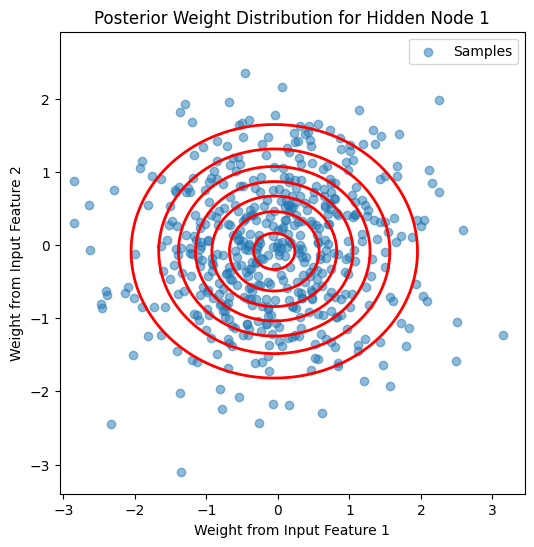

In [ ]:
# ------------------------------
# 6. Main Function
# ------------------------------
def main():
    X, y = create_dummy_data()
    print("Dummy Data X:\n", X)
    print("Dummy Data y:\n", y)
    train_model(X, y)
    evaluate_model(X, y)
    plot_hidden_node_weights()

if __name__ == "__main__":
    main()

Dummy Data X:
 tensor([[0.1000, 0.2000],
        [0.2000, 0.1000],
        [0.4000, 0.2000],
        [0.2000, 0.3000],
        [0.9000, 0.8000],
        [0.8000, 0.9000],
        [0.3000, 0.2000],
        [0.5000, 0.6000],
        [0.6000, 0.5000],
        [0.7000, 0.8000]])
Dummy Data y:
 tensor([0., 0., 0., 0., 1., 1., 0., 1., 1., 1.])

Boosting iteration 1
Step 0: Loss = -8.871315002441406
Step 500: Loss = -52.880706787109375
Step 1000: Loss = -23.76250457763672
Step 1500: Loss = 10.15951156616211
Component 1 training complete. Final loss: -74.27
Updated mixture weights: [0.0, 1.0]

Boosting iteration 2
Step 0: Loss = -18.428211212158203
Step 500: Loss = -24.194007873535156
Step 1000: Loss = -4.153163909912109
Step 1500: Loss = -23.36658477783203
Component 2 training complete. Final loss: -167.56
Updated mixture weights: [0.0, 0.5, 0.5]
Boosted Model Accuracy: 100.00%
Aggregated Predictions: tensor([[0., 0., 0., 0., 1., 1., 0., 1., 1., 1.]])
True Labels: tensor([0., 0., 0., 0., 1., 

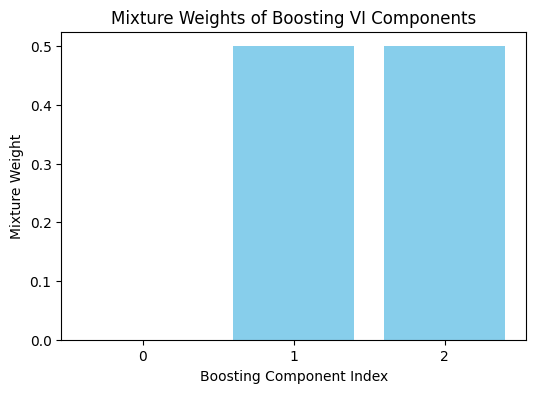

In [2]:
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from functools import partial
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. Create Dummy Data
# ------------------------------
def create_dummy_data():
    # 10 datapoints, 2 features each
    X = torch.tensor([
        [0.1, 0.2],
        [0.2, 0.1],
        [0.4, 0.2],
        [0.2, 0.3],
        [0.9, 0.8],
        [0.8, 0.9],
        [0.3, 0.2],
        [0.5, 0.6],
        [0.6, 0.5],
        [0.7, 0.8]
    ], dtype=torch.float32)
    # Binary labels: 1 if sum > 0.8, else 0.
    y = (X.sum(dim=1) > 0.8).float()
    return X, y

# ------------------------------
# 2. Define the Bayesian Neural Network Model
#    Architecture: 2-3-1 (input-hidden-output)
# ------------------------------
def model(X, y=None):
    batch_size = X.shape[0]
    # First layer: weights shape (2, 3) and biases shape (3)
    w1 = pyro.sample("w1", dist.Normal(torch.zeros(2, 3), torch.ones(2, 3)).to_event(2))
    b1 = pyro.sample("b1", dist.Normal(torch.zeros(3), torch.ones(3)).to_event(1))
    # Second layer: weights shape (3, 1) and bias scalar
    w2 = pyro.sample("w2", dist.Normal(torch.zeros(3, 1), torch.ones(3, 1)).to_event(2))
    b2 = pyro.sample("b2", dist.Normal(torch.tensor(0.0), torch.tensor(1.0)))
    
    hidden = torch.relu(torch.matmul(X, w1) + b1)
    logits = torch.matmul(hidden, w2) + b2
    # Record logits deterministically for evaluation.
    pyro.deterministic("logits", logits.squeeze(-1))
    probs = torch.sigmoid(logits).squeeze(-1)
    
    with pyro.plate("data", batch_size):
        pyro.sample("obs", dist.Bernoulli(probs), obs=y)

# ------------------------------
# 3. Define the Boosted Guide
#    Each component uses its own set of variational parameters (indexed)
# ------------------------------
def boosted_guide(X, y=None, index=0):
    # First layer variational parameters
    w1_loc = pyro.param(f"w1_loc_{index}", torch.zeros(2, 3))
    w1_scale = pyro.param(f"w1_scale_{index}", torch.ones(2, 3),
                           constraint=dist.constraints.positive)
    b1_loc = pyro.param(f"b1_loc_{index}", torch.zeros(3))
    b1_scale = pyro.param(f"b1_scale_{index}", torch.ones(3),
                           constraint=dist.constraints.positive)
    # Second layer variational parameters
    w2_loc = pyro.param(f"w2_loc_{index}", torch.zeros(3, 1))
    w2_scale = pyro.param(f"w2_scale_{index}", torch.ones(3, 1),
                           constraint=dist.constraints.positive)
    b2_loc = pyro.param(f"b2_loc_{index}", torch.tensor(0.0))
    b2_scale = pyro.param(f"b2_scale_{index}", torch.tensor(1.0),
                           constraint=dist.constraints.positive)
    
    pyro.sample("w1", dist.Normal(w1_loc, w1_scale).to_event(2))
    pyro.sample("b1", dist.Normal(b1_loc, b1_scale).to_event(1))
    pyro.sample("w2", dist.Normal(w2_loc, w2_scale).to_event(2))
    pyro.sample("b2", dist.Normal(b2_loc, b2_scale))

# ------------------------------
# 4. Define the Custom RELBO Objective
# ------------------------------
def relbo(model, guide, X, y=None, approximation=None):
    # Compute the standard ELBO loss using the current guide component
    traced_guide = poutine.trace(guide).get_trace(X, y)
    elbo = Trace_ELBO(max_plate_nesting=1)
    loss = elbo.differentiable_loss(model, guide, X, y)
    
    # Use the current approximation (mixture of previous components) to compute its log-probability.
    # We block the latent names so that previous components are not updated.
    replayed_approx = poutine.trace(
        poutine.replay(
            poutine.block(approximation, expose=["w1", "b1", "w2", "b2"]),
            traced_guide
        )
    ).get_trace(X, y)
    
    relbo_value = -loss - replayed_approx.log_prob_sum()
    # SVI minimizes the loss so we return negative of relbo_value.
    return -relbo_value

# ------------------------------
# 5. Define the Mixture Approximation
#    This function samples a component according to mixture weights and calls its guide.
# ------------------------------
def approximation(X, y, components, weights):
    assignment = pyro.sample("assignment", dist.Categorical(weights))
    return components[assignment.item()](X, y)

# ------------------------------
# 6. Boosted Training Loop
# ------------------------------
def train_boosted_model(X, y, n_iterations=2, n_steps=2000):
    pyro.clear_param_store()
    # Start with an initial component (index=0)
    initial_component = partial(boosted_guide, index=0)
    # Make y optional in the lambda wrapper (defaulting to None)
    components = [lambda X, y=None: initial_component(X, y)]
    weights = torch.tensor([1.0])
    wrapped_approximation = partial(approximation, components=components, weights=weights)
    
    optimizer_params = {"lr": 0.01, "betas": (0.90, 0.999)}
    
    # For tracking weights over iterations
    mixture_weights_history = [weights.clone()]
    
    for t in range(1, n_iterations + 1):
        print(f"\nBoosting iteration {t}")
        new_component = partial(boosted_guide, index=t)
        # Wrap to standardize the signature with an optional y.
        wrapped_new_component = lambda X, y=None, comp=new_component: comp(X, y)
        
        optimizer = Adam(optimizer_params)
        svi = SVI(model, wrapped_new_component, optimizer,
                  loss=partial(relbo, approximation=wrapped_approximation))
        losses = []
        for step in range(n_steps):
            loss = svi.step(X, y)
            losses.append(loss)
            if step % 500 == 0:
                print(f"Step {step}: Loss = {loss}")
        print(f"Component {t} training complete. Final loss: {losses[-1]:.2f}")
        
        # Append the new guide component to our mixture
        components.append(wrapped_new_component)
        # Update the mixture weights; here a simple rule is used.
        new_weight = 2.0 / (t + 1)
        if t == 2:
            new_weight = 0.5  # special case for demonstration
        weights = weights * (1 - new_weight)
        weights = torch.cat((weights, torch.tensor([new_weight])))
        wrapped_approximation = partial(approximation, components=components, weights=weights)
        print(f"Updated mixture weights: {weights.tolist()}")
        
        mixture_weights_history.append(weights.clone())
    return components, weights, mixture_weights_history


# ------------------------------
# 7. Evaluation Function for the Boosted Model
# ------------------------------
def evaluate_boosted_model(X, y, components, weights, num_samples=1000):
    # Aggregate predictions over the mixture components using their weights.
    aggregated_preds = None
    for i, comp in enumerate(components):
        predictive = Predictive(model, guide=comp, num_samples=num_samples)
        # Note: we call with y omitted (defaulting to None)
        samples = predictive(X)
        # Average the deterministic logits (passed through sigmoid) to get probabilities.
        pred_probs = torch.sigmoid(samples["logits"]).mean(0)
        if aggregated_preds is None:
            aggregated_preds = weights[i] * pred_probs
        else:
            aggregated_preds += weights[i] * pred_probs
    final_preds = (aggregated_preds > 0.5).float()
    accuracy = (final_preds == y).float().mean().item()
    print("Boosted Model Accuracy: {:.2f}%".format(accuracy * 100))
    print("Aggregated Predictions:", final_preds)
    print("True Labels:", y)
# ------------------------------
# 8. Plotting Function for Mixture Weights
# ------------------------------
def plot_mixture_weights(mixture_weights_history):
    # Use the final mixture weights for a bar plot.
    final_weights = mixture_weights_history[-1].detach().cpu().numpy()
    components_idx = np.arange(len(final_weights))
    
    plt.figure(figsize=(6, 4))
    plt.bar(components_idx, final_weights, color='skyblue')
    plt.xlabel("Boosting Component Index")
    plt.ylabel("Mixture Weight")
    plt.title("Mixture Weights of Boosting VI Components")
    plt.xticks(components_idx)
    plt.show()

# ------------------------------
# 9. Main Function
# ------------------------------
def main():
    X, y = create_dummy_data()
    print("Dummy Data X:\n", X)
    print("Dummy Data y:\n", y)
    
    n_iterations = 2  # number of boosting iterations; increase as needed
    components, weights, mixture_weights_history = train_boosted_model(X, y, n_iterations=n_iterations, n_steps=2000)
    evaluate_boosted_model(X, y, components, weights, num_samples=500)
    plot_mixture_weights(mixture_weights_history)
    

if __name__ == "__main__":
    main()

